In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
args = {}
args['dim_h'] = 40            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 20              # number of dimensions in latent space. 
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 0.01           # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 50            # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD
args['save'] = False          # save weights at each epoch of training if True
args['train'] = False         # train networks if True, else load networks from saved weights

## load all encoder and decoder classes

In [3]:
## create encoder model and decoder model
class EncoderD(nn.Module):
    def __init__(self, args):
        super(EncoderD, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x
    
## create encoder model and decoder model
class EncoderS(nn.Module):
    def __init__(self, args):
        super(EncoderS, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc1 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        self.fc2 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
        
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    
    def forward(self, x):
        h = self.conv(x)
        h = h.squeeze()
        z, mu, logvar = self.bottleneck(h)
        
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

## Get final test loss for FMNIST

In [4]:
# set FMNIST test set
dataset = 'FashionMNIST'
testset = datasets.FashionMNIST(
    root='./FMNIST/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

# load the full validation set as batch size
test_loader = DataLoader(
    dataset=testset,
    batch_size=10000,
    shuffle=False
)

In [5]:
# loss for all models
criterion = nn.MSELoss()

In [7]:
%%time

# standard AE
encoder, decoder = EncoderD(args), Decoder(args)
encoder.eval()
decoder.eval()

# load encoder and decoder weights from checkpoint
enc_checkpoint = torch.load('save/AE_encoder-best_fmnist.pth')
encoder.load_state_dict(enc_checkpoint)

dec_checkpoint = torch.load('save/AE_decoder-best_fmnist.pth')
decoder.load_state_dict(dec_checkpoint)

for images, _ in test_loader:
    z_hat = encoder(images)
    x_hat = decoder(z_hat)
    ae_FMNIST_test_recon_loss = criterion(x_hat, images)
    print('AE final reconstruction loss {} on {}'.format(ae_FMNIST_test_recon_loss.data.item(), 
                                                         dataset))

AE final reconstruction loss 0.008342660963535309 on FashionMNIST
CPU times: user 1min 54s, sys: 11.4 s, total: 2min 6s
Wall time: 1min 17s


In [8]:
%%time

# VAE
encoder, decoder = EncoderS(args), Decoder(args)
encoder.eval()
decoder.eval()

# load encoder and decoder weights from checkpoint
enc_checkpoint = torch.load('save/VAE_encoder-best_fmnist.pth')
encoder.load_state_dict(enc_checkpoint)

dec_checkpoint = torch.load('save/VAE_decoder-best_fmnist.pth')
decoder.load_state_dict(dec_checkpoint)

for images, _ in test_loader:
    z_hat, mu, logvar = encoder(images)
    x_hat = decoder(z_hat)
    vae_FMNIST_test_recon_loss = criterion(x_hat, images)
    print('VAE final reconstruction loss {} on {}'.format(vae_FMNIST_test_recon_loss.data.item(), 
                                                          dataset))

VAE final reconstruction loss 0.01371612399816513 on FashionMNIST
CPU times: user 2min 5s, sys: 13.6 s, total: 2min 19s
Wall time: 1min 37s


In [9]:
%%time

#WAE
encoder, decoder = EncoderD(args), Decoder(args)
encoder.eval()
decoder.eval()

# load encoder and decoder weights from checkpoint
enc_checkpoint = torch.load('save/WAEgan_encoder-best_fmnist.pth')
encoder.load_state_dict(enc_checkpoint)

dec_checkpoint = torch.load('save/WAEgan_decoder-best_fmnist.pth')
decoder.load_state_dict(dec_checkpoint)

for images, _ in test_loader:
    z_hat = encoder(images)
    x_hat = decoder(z_hat)
    wae_FMNIST_test_recon_loss = criterion(x_hat, images)
    print('WAE final reconstruction loss {} on {}'.format(wae_FMNIST_test_recon_loss.data.item(), 
                                                          dataset))

WAE final reconstruction loss 0.009289098903536797 on FashionMNIST
CPU times: user 2min 11s, sys: 12.6 s, total: 2min 23s
Wall time: 1min 33s


## MNIST

In [10]:
# set FMNIST test set
dataset = 'MNIST'
testset = datasets.MNIST(
    root='./data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

# load the full validation set as batch size
test_loader = DataLoader(
    dataset=testset,
    batch_size=10000,
    shuffle=False
)

In [14]:
%%time 

# standard AE
encoder, decoder = EncoderD(args), Decoder(args)
encoder.eval()
decoder.eval()

# load encoder and decoder weights from checkpoint
enc_checkpoint = torch.load('save/AE_encoder-best_mnist.pth')
encoder.load_state_dict(enc_checkpoint)

dec_checkpoint = torch.load('save/AE_decoder-best_mnist.pth')
decoder.load_state_dict(dec_checkpoint)

for images, _ in test_loader:
    z_hat = encoder(images)
    x_hat = decoder(z_hat)
    ae_MNIST_test_recon_loss = criterion(x_hat, images)
    print('AE final reconstruction loss {} on {}'.format(ae_MNIST_test_recon_loss.data.item(),
                                                         dataset))

AE final reconstruction loss 0.004806568846106529 on MNIST
CPU times: user 1min 56s, sys: 12.2 s, total: 2min 9s
Wall time: 1min 24s


In [15]:
%%time

# VAE
encoder, decoder = EncoderS(args), Decoder(args)
encoder.eval()
decoder.eval()

# load encoder and decoder weights from checkpoint
enc_checkpoint = torch.load('save/VAE_encoder-best_mnist.pth')
encoder.load_state_dict(enc_checkpoint)

dec_checkpoint = torch.load('save/VAE_decoder-best_mnist.pth')
decoder.load_state_dict(dec_checkpoint)

for images, _ in test_loader:
    z_hat, mu, logvar = encoder(images)
    x_hat = decoder(z_hat)
    vae_MNIST_test_recon_loss = criterion(x_hat, images)
    print('VAE final reconstruction loss {} on {}'.format(vae_MNIST_test_recon_loss.data.item(), 
                                                          dataset))

VAE final reconstruction loss 0.009478049352765083 on MNIST
CPU times: user 2min 9s, sys: 12.9 s, total: 2min 22s
Wall time: 1min 34s


In [16]:
%%time 

#WAE
encoder, decoder = EncoderD(args), Decoder(args)
encoder.eval()
decoder.eval()

# load encoder and decoder weights from checkpoint
enc_checkpoint = torch.load('save/WAEgan_encoder-best_mnist.pth')
encoder.load_state_dict(enc_checkpoint)

dec_checkpoint = torch.load('save/WAEgan_decoder-best_mnist.pth')
decoder.load_state_dict(dec_checkpoint)

for images, _ in test_loader:
    z_hat = encoder(images)
    x_hat = decoder(z_hat)
    wae_MNIST_test_recon_loss = criterion(x_hat, images)
    print('WAE final reconstruction loss {} on {}'.format(wae_MNIST_test_recon_loss.data.item(), 
                                                          dataset))

WAE final reconstruction loss 0.00714739877730608 on MNIST
CPU times: user 2min 5s, sys: 12.2 s, total: 2min 17s
Wall time: 1min 34s


In [29]:
model_list = ["auto-encoder", 
              "variational\nauto-encoder", 
              "wasserstein\nauto-encoder"]

fmnist_loss = np.array((ae_FMNIST_test_recon_loss.data.item(), 
                        vae_FMNIST_test_recon_loss.data.item(), 
                        wae_FMNIST_test_recon_loss.data.item()))

mnist_loss = np.array((ae_MNIST_test_recon_loss.data.item(), 
                        vae_MNIST_test_recon_loss.data.item(), 
                        wae_MNIST_test_recon_loss.data.item()))


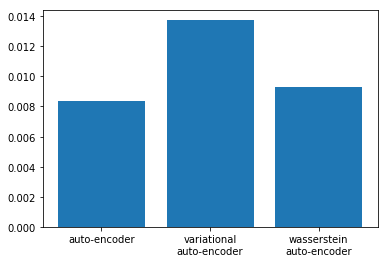

In [27]:
plt.bar(model_list, fmnist_loss)
plt.show()

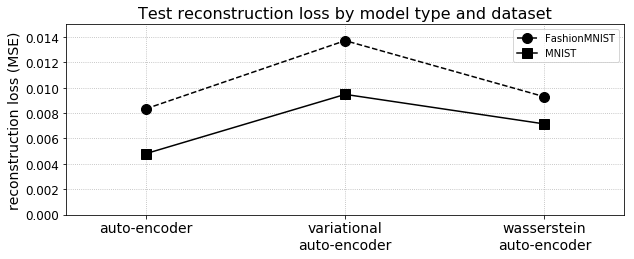

In [59]:
fs=16
fig = plt.figure(figsize=(10,3.5))

plt.plot(model_list, fmnist_loss, "ko--", markersize=10, label="FashionMNIST")
plt.plot(model_list, mnist_loss, "ks-", markersize=10, label="MNIST")
# plt.xlabel("model type", fontsize=fs)
plt.title("Test reconstruction loss by model type and dataset", fontsize=fs)
plt.xticks(fontsize=fs-2)
plt.yticks(fontsize=fs-4)
plt.ylabel("reconstruction loss (MSE)", fontsize=fs-2)
plt.ylim(bottom=0, top=0.015)
plt.margins(x=.2)
plt.grid(linestyle=":")
plt.legend(loc=1)
plt.savefig("./images/reconstruction_loss.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [62]:
print("| MNIST \t|{0:.4f}|{1:.4f}|{2:.4f}|".format(mnist_loss[0], 
                                                   mnist_loss[1], 
                                                   mnist_loss[2]))
print("| FashionMNIST \t|{0:.4f}|{1:.4f}|{2:.4f}|".format(fmnist_loss[0], 
                                                          fmnist_loss[1], 
                                                          fmnist_loss[2]))

| MNIST 	|0.0048|0.0095|0.0071|
| FashionMNIST 	|0.0083|0.0137|0.0093|
